# **Predict Sale Price**

## Objectives

* Create Regressor Pipeline
* Hyperparameter optimization
* Grid Search CV - Sklearn
* Train ML pipeline to predict property sale price.

## Inputs

* outputs/datasets/cleaned/clean_house_price_records.csv

## Outputs

* ML pipeline
* Feature Importance Plot



---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/project-portfolio-5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/project-portfolio-5'

# Import Packages

In [4]:
import numpy as np
import pandas as pd

# Load Data

First we need to merge train and test sets into a new dataset that we'll call clean_house_price_records.

In [7]:
train_data = pd.read_csv('outputs/datasets/cleaned/train_set.csv')
test_data = pd.read_csv('outputs/datasets/cleaned/test_set.csv')

merged_data = pd.concat([train_data, test_data], axis=0)

merged_data.to_csv('outputs/datasets/cleaned/clean_house_price_records.csv', index=False)

Now we can load the data.

In [8]:
df = pd.read_csv(f"outputs/datasets/cleaned/clean_house_price_records.csv")
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,1828,0,0,Av,48,Unk,1774,774,Unf,2007,...,11694,90,452,108,5,9,1822,2007,2007,314813
1,894,0,2,No,0,Unf,894,308,Unf,1962,...,6600,60,0,0,5,5,894,1962,1962,109500
2,964,0,2,No,713,ALQ,163,432,Unf,1921,...,13360,80,0,0,7,5,876,1921,2006,163500
3,1689,0,3,No,1218,GLQ,350,857,RFn,2002,...,13265,69,148,59,5,8,1568,2002,2002,271000
4,1541,0,3,No,0,Unf,1541,843,RFn,2001,...,13704,118,150,81,5,7,1541,2001,2002,205000


## ML Regressor Pipeline

In [9]:
from sklearn.pipeline import Pipeline

### Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### Feat Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


def PipelineOptimization(model):
    pipeline_base = Pipeline([

      ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                   variables=['BsmtExposure',
                                                              'BsmtFinType1',
                                                              'GarageFinish',
                                                              'KitchenQual'])),

      ("NumericLogTransform", vt.LogTransformer(variables=['1stFlrSF',
                                                           'GrLivArea',
                                                           'LotArea'])),
      ("NumericPowerTransform", vt.PowerTransformer(variables=['MasVnrArea'])),
      ("NumericYeoJohnsonTransform", vt.YeoJohnsonTransformer(variables=['OpenPorchSF'])),

      ("SmartCorrelatedSelection",
       SmartCorrelatedSelection(variables=None,
                                method="spearman",
                                threshold=0.6,
                                selection_method="cardinality"
                                )),

      ("feat_scaling", StandardScaler()),

      ("feat_selection",  SelectFromModel(model)),

      ("model", model),

    ])

    return pipeline_base

## Custom Class for hyperparameter Optimization

In [10]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

## Split Train and Test set

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'], axis=1),
                                    df['SalePrice'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


## Grid Search CV - Sklearn

Use default hyperparameters to find most suitable algorithm

In [12]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimisation search using default hyperparameters

In [14]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [15]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.619061,0.790977,0.854621,0.08726
5,GradientBoostingRegressor,0.555235,0.789892,0.86852,0.118582
2,RandomForestRegressor,0.644853,0.789425,0.839751,0.072913
0,LinearRegression,0.610759,0.73133,0.774344,0.061447
4,AdaBoostRegressor,0.590748,0.722481,0.791145,0.068633
6,XGBRegressor,0.550637,0.701211,0.766518,0.077426
1,DecisionTreeRegressor,0.461816,0.630578,0.694971,0.08725


RandomForestRegressor seems to be the best result. The business requirement is an R2 score of 0.75 and RandomForestRegressor has a R2 score of almost 0.80.

We will apply an extensive search on RandomForestRegressor to see if the score improves.

## Extensive Search

Do an extensive search on the most suitable model to find the best hyperparameter configuration.

In [19]:
models_search = {
    "RandomForestRegressor":RandomForestRegressor(random_state=0),
}

params_search = {
    "RandomForestRegressor":{
        'model__n_estimators': [100,600],
        'model__max_depth': [4,14,None],
    }
}

In [20]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


Check results

In [21]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__n_estimators
5,RandomForestRegressor,0.643518,0.79241,0.849217,0.075279,None,600
3,RandomForestRegressor,0.640093,0.791518,0.847983,0.076419,14,600
4,RandomForestRegressor,0.644853,0.789425,0.839751,0.072913,None,100
2,RandomForestRegressor,0.643591,0.788247,0.843321,0.073054,14,100
1,RandomForestRegressor,0.618667,0.751742,0.801253,0.067887,4,600
0,RandomForestRegressor,0.615172,0.747798,0.802676,0.067888,4,100


The score didn't improve drastically after extensive search, but is still around 0.80 with a requirement of 0.75.

We now check the best model

In [22]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestRegressor'

Parameters for the best model

In [23]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': None, 'model__n_estimators': 600}

Define the best regressor, based on search

In [24]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('NumericLogTransform',
                 LogTransformer(variables=['1stFlrSF', 'GrLivArea',
                                           'LotArea'])),
                ('NumericPowerTransform',
                 PowerTransformer(variables=['MasVnrArea'])),
                ('NumericYeoJohnsonTransform',
                 YeoJo...
                                                     'GarageFinish',
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                   

## Assess feature importance

* These are the 4 most important features in descending order. The model was trained on them: 
['GrLivArea', 'YearBuilt', '1stFlrSF', 'GarageArea']


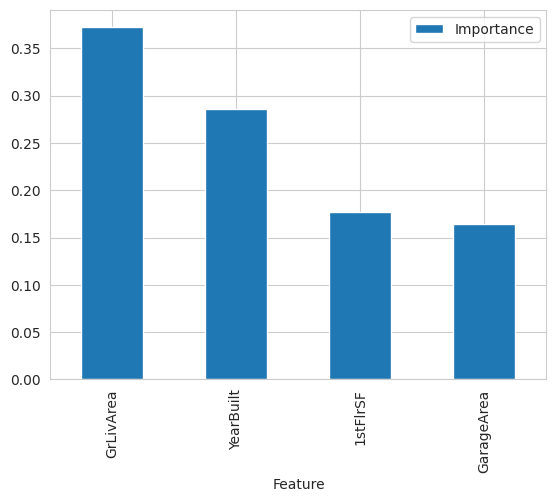

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 5
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

## Evaluate Pipeline performance on Train and Test Sets

In [26]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
	print("Model Evaluation \n")
	print("* Train Set")
	regression_evaluation(X_train,y_train,pipeline)
	print("* Test Set")
	regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X,y,pipeline):
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")

  plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.971
Mean Absolute Error: 8521.27
Mean Squared Error: 189950194.45
Root Mean Squared Error: 13782.242


* Test Set
R2 Score: 0.786
Mean Absolute Error: 21751.02
Mean Squared Error: 1141182758.764
Root Mean Squared Error: 33781.397




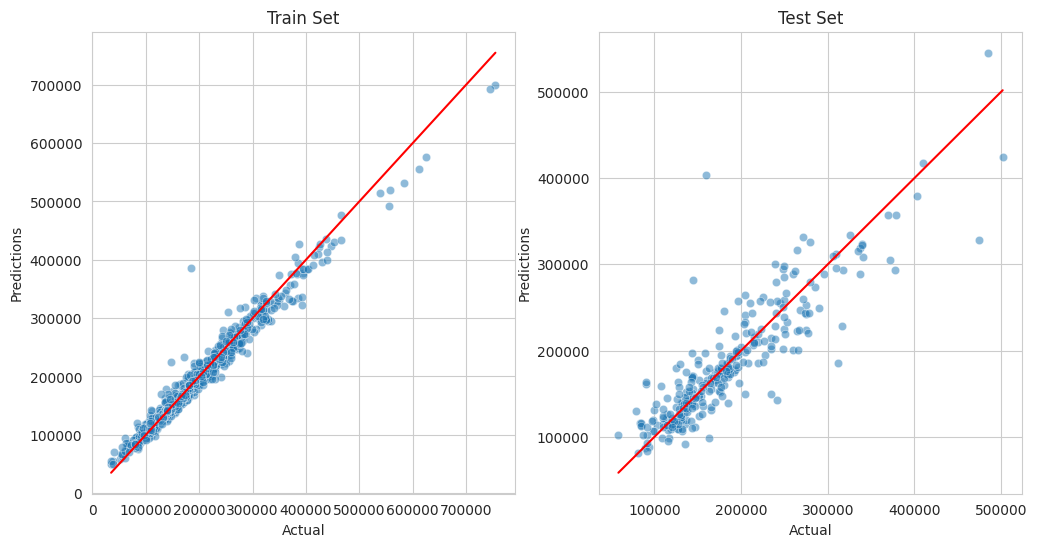

In [27]:

regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

## Regressor with PCA

Let's explore potential values for PCA n_components.

In [28]:
pipeline = PipelineOptimization(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:6])
df_pca = pipeline_pca.fit_transform(df.drop(['SalePrice'],axis=1))

print(df_pca.shape,'\n', type(df_pca))

(1460, 17) 
 <class 'numpy.ndarray'>


Apply PCA separately to the scaled data

* The 17 components explain 100.0% of the data 



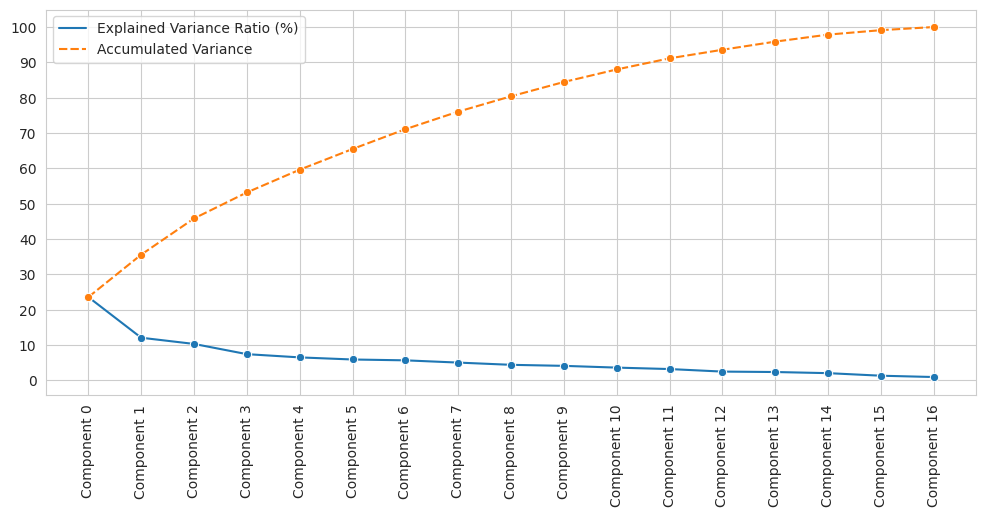

In [29]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 17

def pca_components_analysis(df_pca,n_components): 
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca) # array with transformed PCA

    ComponentsList = ["Component " + str(number) for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data= np.round(100 * pca.explained_variance_ratio_ ,3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum() 

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum()

    print(f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12,5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()

pca_components_analysis(df_pca=df_pca,n_components=n_components)

* The 9 components explain 80.39% of the data 



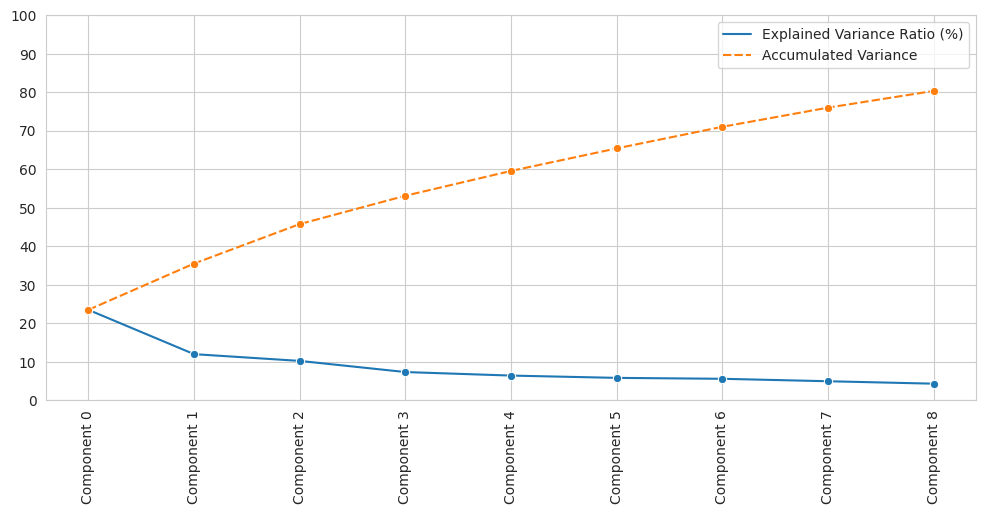

In [30]:
n_components = 9
pca_components_analysis(df_pca=df_pca,n_components=n_components)

## Rewrite ML Pipeline for Modelling

In [31]:
from sklearn.decomposition import PCA


def PipelineOptimization(model):
    pipeline_base = Pipeline([

      ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                   variables=['BsmtExposure',
                                                              'BsmtFinType1',
                                                              'GarageFinish',
                                                              'KitchenQual'])),

      ("NumericLogTransform", vt.LogTransformer(variables=['1stFlrSF',
                                                           'LotArea',
                                                           'GrLivArea'])),
      ("NumericPowerTransform", vt.PowerTransformer(variables=['GarageArea',
                                                               'MasVnrArea'])),
      ("NumericYeoJohnsonTransform",
       vt.YeoJohnsonTransformer(variables=['OpenPorchSF'])),

      ("SmartCorrelatedSelection",
       SmartCorrelatedSelection(variables=None,
                                method="spearman",
                                threshold=0.6,
                                selection_method="cardinality"
                                )),

      ("feat_scaling", StandardScaler()),

      ("PCA", PCA(n_components=9, random_state=0)),

      ("model", model),

    ])

    return pipeline_base

## Grid Search CV – Sklearn

In [32]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


## Use standard hyperparameters to find most suitable model

In [33]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a quick optimisation search.

In [34]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [35]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,GradientBoostingRegressor,0.636879,0.786388,0.844124,0.078025
2,RandomForestRegressor,0.682319,0.78423,0.834178,0.054578
3,ExtraTreesRegressor,0.648659,0.783692,0.828872,0.068238
6,XGBRegressor,0.638822,0.76886,0.826851,0.068524
0,LinearRegression,0.664976,0.724496,0.76049,0.033897
4,AdaBoostRegressor,0.570448,0.72072,0.784904,0.077531
1,DecisionTreeRegressor,0.437516,0.619351,0.744452,0.106438


## Do an extensive search on the most suitable model to find the best hyperparameter configuration.

In [36]:
models_search = {
    "RandomForestRegressor":RandomForestRegressor(random_state=0),
}

params_search = {
    "RandomForestRegressor":{
        'model__n_estimators': [100,600],
        'model__max_depth': [4,14,None],
    }
}

Extensive GridSearch CV

In [37]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


Check results

In [38]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__n_estimators
3,RandomForestRegressor,0.680517,0.785383,0.833755,0.056568,14,600
5,RandomForestRegressor,0.68014,0.784584,0.833457,0.056508,None,600
4,RandomForestRegressor,0.682319,0.78423,0.834178,0.054578,None,100
2,RandomForestRegressor,0.681882,0.78337,0.831633,0.05471,14,100
1,RandomForestRegressor,0.668137,0.767578,0.810909,0.055872,4,600
0,RandomForestRegressor,0.676191,0.767156,0.808031,0.051602,4,100


Check the best model

In [39]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestRegressor'

Parameters for best model

In [48]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': 14, 'model__n_estimators': 600}

Define the best regressor

In [41]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('NumericLogTransform',
                 LogTransformer(variables=['1stFlrSF', 'LotArea',
                                           'GrLivArea'])),
                ('NumericPowerTransform',
                 PowerTransformer(variables=['GarageArea', 'MasVnrArea'])),
                ('NumericYeoJohnsonTra...
                                                     'BsmtUnfSF', 'GarageArea',
                                                     'GarageFinish',
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                       

## Evaluate Regressor on Train and Tests Sets

Model Evaluation 

* Train Set
R2 Score: 0.967
Mean Absolute Error: 9029.809
Mean Squared Error: 212744122.69
Root Mean Squared Error: 14585.751


* Test Set
R2 Score: 0.752
Mean Absolute Error: 21355.076
Mean Squared Error: 1321821060.055
Root Mean Squared Error: 36356.857




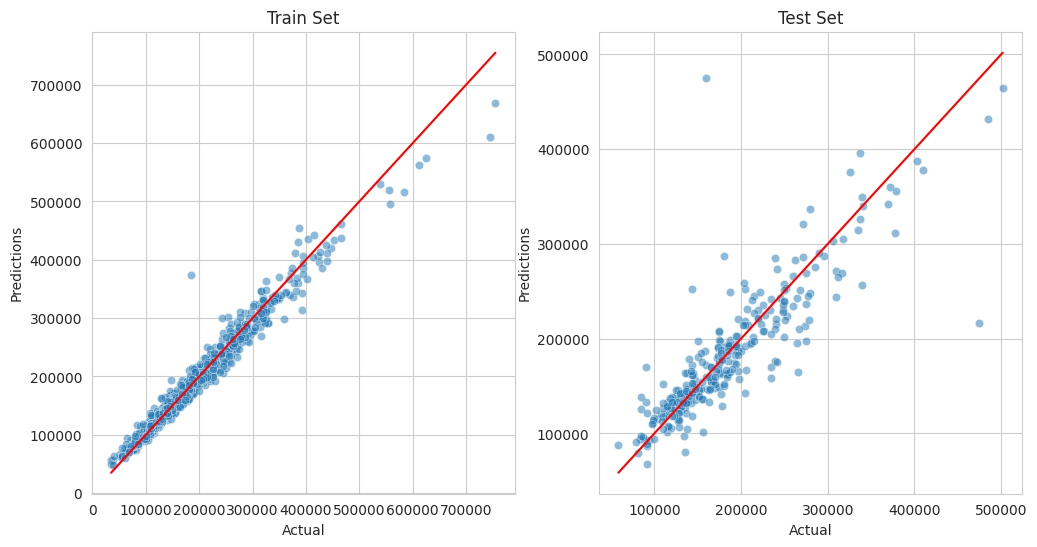

In [43]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline)

Feature selection performed slightly better than PCA, with and R2 score of 0.97 on train sdet and 0.79 on test set.

We will then be using the Feature selection pipeline.

## Subset best features

In [44]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:", X_test.shape, y_test.shape)
X_train.head()

* Train set: (1168, 4) (1168,) 
* Test set: (292, 4) (292,)


,1stFlrSF,GarageArea,GrLivArea,YearBuilt
618,1218,676,1218,2009
870,1055,905,2263,2001
92,955,386,955,1966
817,1175,575,1982,1989
302,1079,501,1953,1992


## Refit pipeline with best features

In [45]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

      ("NumericLogTransform", vt.LogTransformer(variables=['1stFlrSF',
                                                           'GrLivArea'])),

      ("feat_scaling", StandardScaler()),

      ("model", model),

    ])

    return pipeline_base

## Grid Search CV – Sklearn

We are using the same model from the previous GridCV search

In [46]:
models_search

{'RandomForestRegressor': RandomForestRegressor(random_state=0)}

And the best parameters from the previous GridCV search

In [49]:
best_parameters

{'model__max_depth': 14, 'model__n_estimators': 600}

Add the above parameters in manually

In [50]:
params_search = {
    'RandomForestRegressor':  {
        'model__max_depth': [14],
        'model__n_estimators': [600]
        }
    }
params_search

{'RandomForestRegressor': {'model__max_depth': [14],
  'model__n_estimators': [600]}}

GridSearch CV

In [51]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [52]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__n_estimators
0,RandomForestRegressor,0.638286,0.783047,0.8243,0.072445,14,600


Check the best model

In [53]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestRegressor'

Define the best regressor pipeline

In [54]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('NumericLogTransform',
                 LogTransformer(variables=['1stFlrSF', 'GrLivArea'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=14, n_estimators=600,
                                       random_state=0))])

## Assess feature importance

* These are the 4 most important features in descending order. The model was trained on them: 
Index(['1stFlrSF', 'GarageArea', 'GrLivArea', 'YearBuilt'], dtype='object')


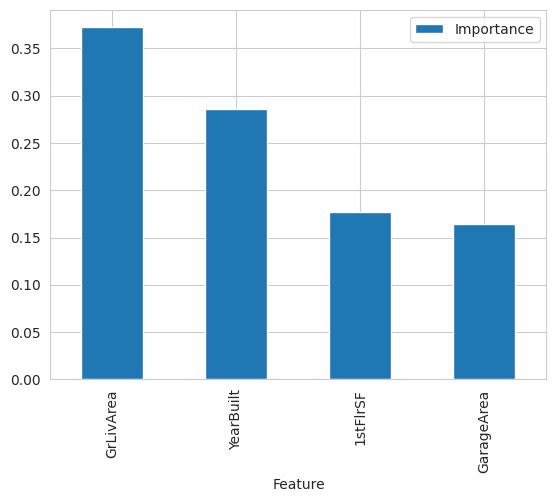

In [55]:
# how many data cleaning and feature engineering does your pipeline have?
data_cleaning_feat_eng_steps = 1 
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng,
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

## Evaluate Pipeline performance on Train and Test Sets

Model Evaluation 

* Train Set
R2 Score: 0.969
Mean Absolute Error: 9028.471
Mean Squared Error: 200762274.263
Root Mean Squared Error: 14169.06


* Test Set
R2 Score: 0.786
Mean Absolute Error: 21733.59
Mean Squared Error: 1144948252.927
Root Mean Squared Error: 33837.084




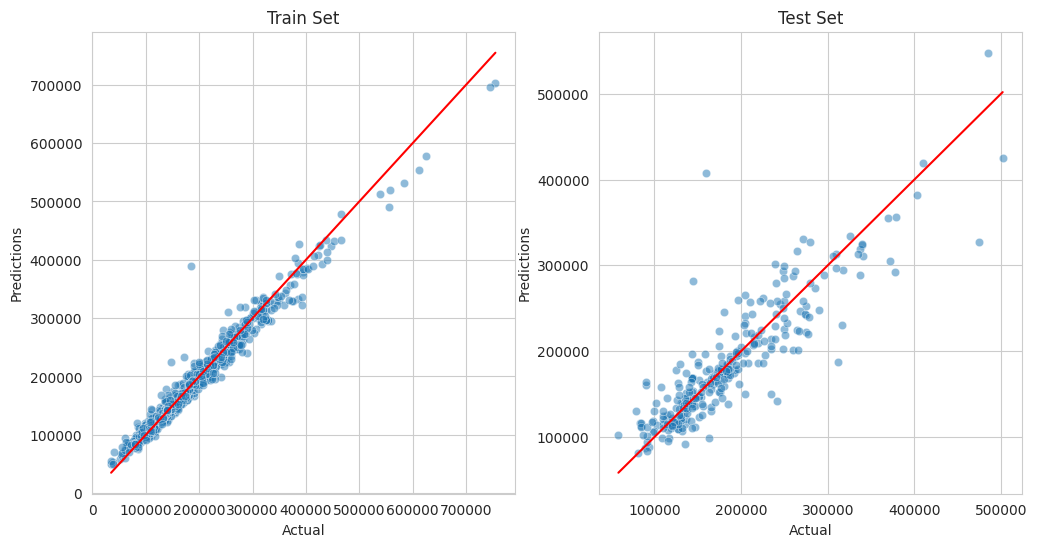

In [56]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

---

# Push files to Repo

We will generate the following files

* Train set
* Test set
* Modeling pipeline
* Features importance plot

In [68]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_saleprice/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_saleprice/v1'


## Train Set : features and target

In [58]:
X_train.head()


,1stFlrSF,GarageArea,GrLivArea,YearBuilt
618,1218,676,1218,2009
870,1055,905,2263,2001
92,955,386,955,1966
817,1175,575,1982,1989
302,1079,501,1953,1992


In [59]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [61]:
y_train.head()

618    208300
870    287000
92     127000
817    228500
302    240000
Name: SalePrice, dtype: int64

In [62]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: features and target

In [63]:
X_test.head()

,1stFlrSF,GarageArea,GrLivArea,YearBuilt
529,1468,539,2263,1977
491,1610,789,2161,2007
459,1668,702,1668,2002
279,1167,400,1167,1992
655,624,513,1344,1916


In [64]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [65]:
y_test.head()

529    235000
491    325624
459    285000
279    173000
655     98000
Name: SalePrice, dtype: int64

In [66]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling pipeline

In [67]:
best_regressor_pipeline

Pipeline(steps=[('NumericLogTransform',
                 LogTransformer(variables=['1stFlrSF', 'GrLivArea'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=14, n_estimators=600,
                                       random_state=0))])

In [69]:
joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/best_regressor_pipeline.pkl")

['outputs/ml_pipeline/predict_saleprice/v1/best_regressor_pipeline.pkl']

## Feature importance plot

In [ ]:
df_feature_importance.to_csv(f"{file_path}/feature_importance.csv", index=False)

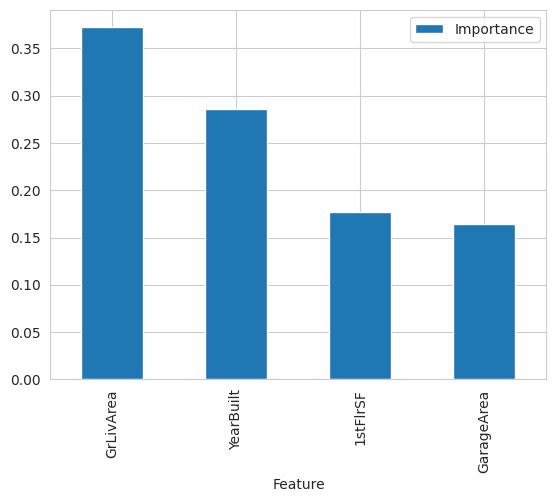

In [70]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/feature_importance.png', bbox_inches='tight')